## Entire Notebook Runtime = 10 minutes

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import sklearn
import yellowbrick
import re
import mglearn
import nltk 
from nltk.stem import WordNetLemmatizer 
import boto3
from s3 import get_file

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/externals/six.py:28: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  warnings.warn("The module is deprecated in version 0.21 and will be removed "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals

In [3]:
s3 = boto3.resource('s3')
lyrics = get_file(s3,'s3ssp',download_file='NLP_Data/master_lyrics_audio_features.csv',rename_file='nlp0614.csv')

df = pd.read_csv('0320_2020_nlp.csv',sep='|',encoding='utf-8')
df_demo = df.copy().dropna()

In [4]:
df = pd.read_csv(lyrics,sep='|',encoding='utf-8')
df_demo = df.copy().dropna()

## Simulation of User Spotify Liked Library

In [5]:
X = df_demo.sample(5000)

In [6]:
def LDA_hyper_params(df):
    
    df_topic_rows = df.shape[0]
    
    if(df_topic_rows in range(100,1000)):
        return {'max_features':500, 'n_components':3, 'n_words':10}
    
    elif(df_topic_rows in range(1001,4000)):
        return {'max_features':200, 'n_components' :5, 'n_words':10} 
        
    elif(df_topic_rows in range(4001,6000)):
        return {'max_features':500, 'n_components' :5, 'n_words':10} 
    
    elif(df_topic_rows in range(6001,8000)):
        return {'max_features':400, 'n_components' :5, 'n_words':10} 
    
    elif(df_topic_rows in range(8001,10000)):
        return {'max_features':500, 'n_components' :5, 'n_words':10}
    
    elif(df_topic_rows >= 10000):
        return {'max_features':600, 'n_components' :5, 'n_words':10}
    else:
        return None

## Optimize max_features, n_components (used to be no_topics), n_words

In [7]:
#Control Panel - Hyper Parameters

hp = LDA_hyper_params(X)

#Count Vectorizer
max_features = hp['max_features']
max_df = .20



#LDA
n_components = hp['n_components']  #10


#LDA Display
display_n_chunks = 5 #5
n_components = hp['n_components']        #20
n_words = hp['n_words']       #5


print(max_features,n_components,n_words)

500 5 10


## Top Word Count

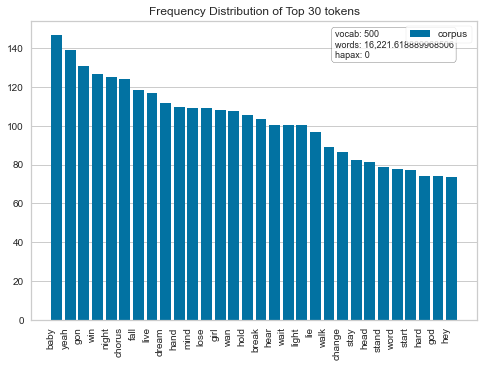

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 

from yellowbrick.text import FreqDistVisualizer

# Load the text data


vect = TfidfVectorizer(max_features=max_features, max_df=max_df,stop_words='english',token_pattern='[a-zA-Z0-9]{3,}')
docs      = vect.fit_transform(X['lyrics'])
features   = vect.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v',n=30)
visualizer.fit(docs)
visualizer.show()

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=n_components, learning_method="batch",
                                max_iter=35, random_state=0,doc_topic_prior=3000,topic_word_prior=.3)


# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once

document_topics = lda_model.fit_transform(docs)

vectorizer = TfidfVectorizer(analyzer='word',       
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(X['lyrics'])

# Build LDA Model
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())


#print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda_model.components_, axis=1)#[:, ::-1]

# Get the feature names from the vectorizer
feature_names = np.array(vectorizer.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)

# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(X))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic#.nlargest(n=100,columns='Topic7')#.style.applymap(color_green).applymap(make_bold)

df_document_topics.sum()


LatentDirichletAllocation(batch_size=128, doc_topic_prior=3000,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=35,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=0.3,
                          total_samples=1000000.0, verbose=0)
Log Likelihood:  -186283.73011954158
Perplexity:  4843.685945277054
{'batch_size': 128, 'doc_topic_prior': 3000, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 35, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': 0.3, 'total_samples': 1000000.0, 'verbose': 0}
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------    

Topic0            1000.0
Topic1            1000.0
Topic2            1000.0
Topic3            1000.0
Topic4            1000.0
dominant_topic       0.0
dtype: float64

In [11]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,love,time,feel,day,life,gon,win,wan,heart,leave,eye,baby,light,hand,chorus
Topic 1,love,feel,time,life,day,yeah,gon,leave,heart,baby,dream,girl,night,wait,eye
Topic 2,love,time,feel,night,heart,day,baby,leave,girl,eye,fall,chorus,life,live,light
Topic 3,love,time,feel,life,hold,yeah,live,heart,day,baby,gon,walk,mind,break,win
Topic 4,love,time,baby,feel,fall,heart,gon,win,yeah,leave,life,chorus,wait,lose,day


## Topic Analysis

In [39]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_components, learning_method="batch",
                                max_iter=10, random_state=0, doc_topic_prior=3000)


# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once

document_topics = lda.fit_transform(docs)

print("lda.components_.shape: {}".format(lda.components_.shape))

# For each topic (a row in the components_), sort the features (ascending)
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)#[:, ::-1]


# Get the feature names from the vectorizer
feature_names = np.array(vect.get_feature_names())

# Print out the 10 topics:
mglearn.tools.print_topics(topics=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words)





lda.components_.shape: (5, 500)
topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
woo           woo           hoe           dip           wit           
melody        doo           doo           dime          dit           
sugar         dip           dip           style         dip           
sister        pop           tryin         cash          murder        
doo           talkin        walkin        jump          huh           
club          doin          boom          pack          bag           
feelin        band          simple        family        yesterday     
mad           shot          yea           prayer        bang          
stuff         knock         doin          shoulder      gettin        
drunk         walkin        dit           boom          woo           




In [12]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  20.000017
3       51.163364 -159.968018       2        1  20.000009
0      -73.144554   21.523815       3        1  20.000001
1      -66.410133 -110.606438       4        1  20.000001
4       54.417324   12.443444       5        1  19.999973, topic_info=         Term       Freq      Total Category  logprob  loglift
4919  whisper   9.000000   9.000000  Default  30.0000  30.0000
4523      tie   9.000000   9.000000  Default  29.0000  29.0000
4147    speak  16.000000  16.000000  Default  28.0000  28.0000
383       bit  13.000000  13.000000  Default  27.0000  27.0000
1839    glass   8.000000   8.000000  Default  26.0000  26.0000
...       ...        ...        ...      ...      ...      ...
1991     hard   9.374307  39.900705   Topic5  -6.1493   0.1610
2024     hear   9.759413  50.718635   Topic5  -6.1090  -0.0386
493     break   9.787644  53.452172   Topic5  -6.1061  -0.0882
2934    night   9.935748  65.708897   Topic5  -6.0911  -0.2797
1324    dream   9.719231  59.282347   Topic5  -6.1131  -0.1988

[405 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
14        3  0.766077  accept
147       1  0.065272  answer
147       2  0.456904  answer
147       3  0.261088  answer
147       4  0.065272  answer
...     ...       ...     ...
5015      3  0.140668    yeah
5015      4  0.225069    yeah
5015      5  0.225069    yeah
5021      1  0.799340  yellow
5026      2  0.856534    york

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

## Assemble Playlist

In [47]:
def get_playlist_elements(components=range(n_components), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=display_n_chunks, n_words=n_words):
    topics_words = []
    
    for i in range(0, len(components), topics_per_chunk):
        # for each chunk:
        these_topics = components[i: i + topics_per_chunk]
        
        for t in these_topics:
            
            topic_words = []
            
            for i in range(n_words):
                
                try:
                    #print(("{:<14}" * len_this_chunk).format(
                    #    *feature_names[sorting[these_topics, i]]))
                    topics_words.append({'topic':f'topic{t}','word':feature_names[sorting[these_topics, i]][t]})
                except:
                    pass
        
    return topics_words

In [48]:
playlist_elements = get_playlist_elements()

In [49]:
df_playlist_elements = pd.DataFrame(playlist_elements)

In [50]:
list_df_words = df_playlist_elements['word'].tolist()
list_df_topics = set(df_playlist_elements['topic'].tolist())

In [51]:
def find_lyrics(lyrics,element,track_uri):
    
    if(lyrics.find(element)!= -1):
        
        return track_uri
    
    else:
        
        return None


In [52]:
def make_ssp(topics,words):
    topics_words = df_playlist_elements.copy()
    
    df_lyrics = df_demo.copy()
    
    df_empty = pd.DataFrame()
    
    ssp = []
    
    #Set df_demo_ssp to topic number

    topics_words = topics_words[(topics_words['topic']== f'topic{topic}')]
    
    df_demo_ssp_wordset = topics_words['word'].tolist()

    for word in df_demo_ssp_wordset:
        
        df_empty[f'{word}'] = df_lyrics.apply(lambda x: find_lyrics(x['lyrics'],word,x['track_uri']),axis=1)



    return df_empty


## Takes 8 minutes

In [53]:
list_ssp = []

for topic in range(len(list_df_topics)):
    
    ssp = make_ssp(topic,list_df_words)

    
    df_ssp = ssp.dropna(how='all')
    
    for x in range(100):
        
        for col in df_ssp.columns:
            
            df_ssp_col = df_ssp[col].dropna(how='any')
            
            col_track_uri = df_ssp_col.sample(1).values
            
            list_ssp.append({'playlist':f'topic{topic}playlist{x}','track_uri':col_track_uri[0]})


In [54]:
sample_ssp = pd.DataFrame(list_ssp)
df_track_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri')
df_agg_ssp = sample_ssp.merge(df_demo,left_on='track_uri',right_on='track_uri').groupby('playlist').median()

In [55]:
ssp = df_track_ssp[df_track_ssp['playlist']=='topic0playlist1'].sort_values(by='valence',ascending=True)

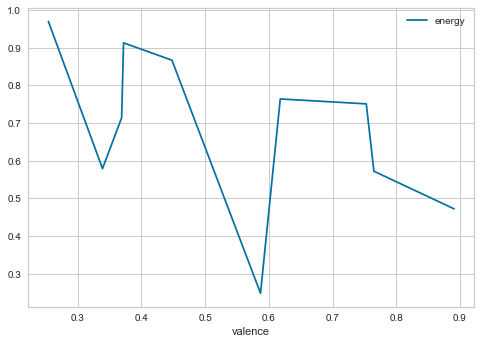

In [56]:
ssp.plot.line(x='valence',y='energy')

## Save SSP

In [ ]:
#df_sample_ssp.to_csv('test_ssp.csv',sep='|',index=True)

## Below is Under Development

In [ ]:
## Visualization (Valence Curve, Energy Curve)

In [ ]:
## Create Spotify Playlist

In [57]:
import requests
import json
import pandas as pd
import spotipy#authentication
import spotipy.util as util#authentication
from spotipy.oauth2 import SpotifyClientCredentials#authentication

In [58]:
cid = 'f61689bf814a44dab11d7e63d18dc38a'
secret = 'a6ec5497f63a40cc84c3da300f152573'
redirect_uri = 'http://google.com/'
username = 'name'

In [60]:
#Authentication

scope = 'playlist-modify-private'
token_playlist = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_playlist:
    
    sp_playlist = spotipy.Spotify(auth=token_playlist)

else:
    
    print("Can't get token for", username)
    
#Authentication

scope = 'user-read-private'

token_user = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token_user:
    sp_user = spotipy.Spotify(auth=token_user)
else:
    print("Can't get token for", username)

Enter the URL you were redirected to: https://www.google.com/?code=AQAbZSJgPWeWr3ATya4yANHIfitDF59D4Q_U5JrWQK7dVwdMp6mkekXjtQiLslorLEvKPPIcyvIKmT54p6vM2wqbQ-BFOCv9nUPpzQyQlAa-Q8IHNHGWqYYBJoFwi6lOdmWfZYfrAanZWBbHIBW44nVWSxfrpj41MQa9UL1FC67Dhiz_3Oc7S2L79kHJpJM
Enter the URL you were redirected to: https://www.google.com/?code=AQAK5sX2jLXN8TyZdZVgawdDExsja6TcDXPAAB3FF85ihNIMhiOoofc1W4IKfNLrumEICDOf2TcJ7frgleFESsj78rXn8_ipg3OQb9THqCq0KzUlQbRS_-PEgafImALDBWoZL432SSLHQvF9s3-txOlI8_I6hB_qx3sv6S7UudwW-CASGr_-Ecw


In [61]:
def get_user_id(url):
    try:
        resp = requests.get(url,headers={'Authorization': 'Bearer ' + token_user},
                             #data={"name": "SSP"}
                           )
        
        resp.raise_for_status()
        
    except requests.exceptions.HTTPError as err:
        
        print(err)
        
    
    response = resp.json()
    userid = response['id']
    
    return userid


In [62]:
user_id = get_user_id('https://api.spotify.com/v1/me')

In [63]:
identification = user_id
identification

'31tabw4566sgjjakrw5afmpspdv4'

In [64]:
playlist = sp_playlist.user_playlist_create(identification,'SSP_Ideal', public=False, description="Ideal SSP")

In [65]:
playlist

{'collaborative': False,
 'description': 'Ideal SSP',
 'external_urls': {'spotify': 'https://open.spotify.com/playlist/6LjNikHiHi6EL8u10ehEDf'},
 'followers': {'href': None, 'total': 0},
 'href': 'https://api.spotify.com/v1/playlists/6LjNikHiHi6EL8u10ehEDf',
 'id': '6LjNikHiHi6EL8u10ehEDf',
 'images': [],
 'name': 'SSP_Ideal',
 'owner': {'display_name': 'Patricia Merino',
  'external_urls': {'spotify': 'https://open.spotify.com/user/31tabw4566sgjjakrw5afmpspdv4'},
  'href': 'https://api.spotify.com/v1/users/31tabw4566sgjjakrw5afmpspdv4',
  'id': '31tabw4566sgjjakrw5afmpspdv4',
  'type': 'user',
  'uri': 'spotify:user:31tabw4566sgjjakrw5afmpspdv4'},
 'primary_color': None,
 'public': False,
 'snapshot_id': 'MSxkOWYzMmM5NzRjOTZjM2MzMTExN2ZhMTM3MTIwYTgxYjkxMGFhZjgy',
 'tracks': {'href': 'https://api.spotify.com/v1/playlists/6LjNikHiHi6EL8u10ehEDf/tracks',
  'items': [],
  'limit': 100,
  'next': None,
  'offset': 0,
  'previous': None,
  'total': 0},
 'type': 'playlist',
 'uri': 'spotify:

In [66]:
playlist_tracks = sp_playlist.user_playlist_add_tracks(identification,playlist['id'],ssp['track_uri'], position=None)

## End

## Sample Topic Analysis Code

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {i}:".format(i=topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
#How many words per topic
no_top_words = 4
display_topics(nmf, tfidf_feature_names, no_top_words)